<a href="https://colab.research.google.com/github/maryRi-developer/Clustering-textMining/blob/main/PracticoClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering

Material a entregar (digital, no papel): Una página web con una notebook ejecutable (tipo github o colab) con:

    descripción del preproceso aplicado al corpus

    descripción de la herramienta de clustering utilizada

    listado de los parámetros usados en la(s) solucion(es) de clustering que se presentan, y lo que se esperaba a priori de cada configuración de parámetros

    discusión de la(s) solucion(es) de clustering elegidas: descripción global de la solución (número de clusters, cantidad de elementos por cluster, distribución de características, algunas métricas) y descripción cualitativa de algunos clusters



   

## 1- Obtener corpus
Obtener un corpus de la lengua española (por ejemplo, alguno del SBWCE de Cristian Cardellino, o, a falta de mejores opciones, se pueden usar los que hay en mi directorio de corpus).

In [ ]:
!pip install es-lemmatizer
#!pip install visualise-spacy-tree
!pip3 install visualise-spacy-tree
!pip install textacy==0.10.0 pydot
!pip install nltk

     |████████████████████████████████| 3.2 MB 31.3 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0
     |████████████████████████████████| 206 kB 31.7 MB/s 
     |████████████████████████████████| 2.0 MB 56.6 MB/s 
     |████████████████████████████████| 1.6 MB 39.7 MB/s 
     |████████████████████████████████| 134 kB 69.7 MB/s 
  Created wheel for jellyfish: filename=jellyfish-0.8.8-cp37-cp37m-linux_x86_64.whl size=73198 sha256=2e0c237b078c8ce6a4799485653611e438a4f3471cf9378b838370ce77314f08
  Stored in directory: /root/.cache/pip/wheels/82/aa/f4/716387e1f167cbbf911488aa056138152f4d8699c9c9b43ea8
Successfully built jellyfish


In [ ]:
%matplotlib inline
import spacy.cli 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import pickle
import nltk
import os
import sklearn.manifold
from collections import Counter
from nltk.cluster import kmeans, cosine_distance
#####---------
from pathlib import Path
import progressbar
import re
#import visualise_spacy_tree
from IPython.display import Image, display
from textacy.extract import noun_chunks, entities
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from matplotlib import pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', 0)

### Modelo

In [ ]:
spacy.cli.download("es_core_news_sm")# vectors=False, entity=False

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [ ]:
#from es_lemmatizer import lemmatize
import spacy
nlp = spacy.load("es_core_news_sm")
#nlp.add_pipe(lemmatize, after="tagger")

In [ ]:
filename = "lavoztextodump.txt"
text_file = open(filename, "r")
la_voz = text_file.read()
la_voz = la_voz.lower()
text_file.close()

## 2- Preprocesamiento con spacy
Preprocesarlo para normalizar las palabras, con SpaCy, NLTK o Freeling. Se pueden realizar análisis morfosintáctico o sintáctico, de forma de enriquecer la información asociada a palabras, por ejemplo, con triplas de dependencias.

### Split Sentences

In [ ]:
sentences = []
lengths = []

text_list = list(Path("./").rglob("*.txt"))

# Pre-process text in dir
for path in progressbar.progressbar(text_list):
    file = open(path.resolve(), "r", encoding='utf-8')
    text = file.read().lower()
    file.close()
    text = re.sub('speaker .*:','',text)
    
    for line in text.splitlines():
        doc = nlp(line)
        sents = [sent.text.strip() for sent in doc.sents]
#         sents=line.split(',')
        lens = [len(x.split()) for x in sents]
        
        sentences.extend(sents)
        lengths.extend(lens)

100% (1 of 1) |##########################| Elapsed Time: 0:06:11 Time:  0:06:11


In [ ]:
df_sent = pd.DataFrame({'sent':sentences, 'len':lengths})
df_sent

,sent,len
0,-,1
1,"""lo que sostiene a la pareja es el amor""",9
2,clara crespo (50) y rodolfo martínez (54) no se imaginan uno sin el otro.,14
3,"""prefiero ni pensarlo"", dice clara.",5
4,"hace 26 años que están casados, y tienen cuatro hijas mujeres.",11
...,...,...
84482,una cifra muy baja.,4
84483,-,1
84484,lo multan por andar sin casco en un ómnibus,9
84485,corresponsalía río cuarto.,3


In [ ]:
sentences

['-',
 '"lo que sostiene a la pareja es el amor"',
 'clara crespo (50) y rodolfo martínez (54) no se imaginan uno sin el otro.',
 '"prefiero ni pensarlo", dice clara.',
 'hace 26 años que están casados, y tienen cuatro hijas mujeres.',
 'se conocieron en el ateneo juventus, el movimiento juvenil de capuchinos.',
 'hoy aseguran no estar sorprendidos del tiempo que llevan juntos sino de haber logrado entenderse tan bien.',
 '&#226;&#8364;&#8220;¿qué les gusta y disgusta del otro?',
 '¿qué quisieran cambiarle?',
 '&#226;&#8364;&#8220;rodolfo: me gusta que sea cariñosa, alegre y esté siempre pensando en mí, y que es una gran madre.',
 'me disgustaba que cuando se enojaba no quería hablar, pero ya no lo hace más.',
 'a veces es indecisa pero ya me acostumbré.',
 'no quiero cambiarle nada, que sea como es.',
 '&#226;&#8364;&#8220;clara : me gusta que es una persona emprendedora, alegre, optimista y servicial.',
 'me gustaría que a veces fuera más sutil para decir las cosas.',
 'pienso que la

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4eb13a3790>]],
      dtype=object)

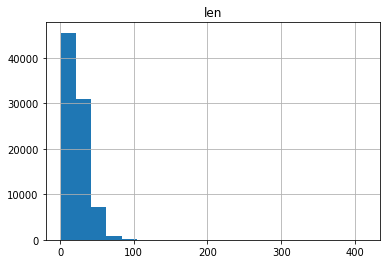

In [ ]:
df_sent.hist(bins=20,column=['len'])

In [ ]:
df_sent[df_sent.len==df_sent.len.max()]

,sent,len
25258,... porque dice umberto eco que leer es un verbo copiosísimo / una estructura rizomática / sabrá eco lo que dice / pero rizomático o no / el verbo leer es un verbo menos prepotente / más bajito / una costumbre / un berretín / conozco a una persona / que soy yo / que antes de dormir elige los libros que meterá entre las sábanas / junto a su cuerpo / dormir con madame bovary / con boquitas pintadas / un poco de mark twain / conozco a otro tipo / que soy yo / que antes de salir / como hacía el sheriff pat garrett con sus pistolas / elige cuidadosamente un libro para llevar calzado en la cintura / como será de rizomático el verbo que / calculando a mano alzada / entre un millón y pico de habitantes que tiene la ciudad / doscientas mil casas / y un millón de pasos cuadrados / viene a salir en el reparto a razón de cinco libros por cabeza / los ladrones de bancos / los carniceros / los enfermos / los empleados de bonafide / cinco libros para cada uno / los libros ayudan a fortalecer el espíritu primero / el cerebro después / o viceversa / un niño puede convertirse en hombre / leyendo / un hombre puede convertirse en dos / si lee a cervantes en tres / y si lee el corazón es un cazador solitario en ocho / imaginen ahora a todos los hombres que caben en la vieja biblioteca vélez sársfield / la más rizomática de todas / yo estaba ahí cuando asumió arturo umberto illia / estaba ahí / leyendo a scott fitzgerald / cuando me crecieron en los pies unos fantásticos tamangos combinados / unos rizomáticos tamangos combinados / quiero decir que pasan los días / pasan las semanas / y resulta que haga lo que haga y esté donde esté / siempre hay cinco libros para cada uno de nosotros / hace dos meses escribí que un hombre que no lee tiene serias chances de convertirse en asesino / todavía no sé por qué lo dije / pero lo hice sin rencor / con mucha pena / un hombre que no lee no sabe a dónde ir / ni cómo volver / supongamos que se declara un incendio / un hombre que lee nunca se achicharra / porque pum va y rompe el cristal / siempre sabe donde se guarda la manguera... tranvías.,414


### Ejemplo Tokenization

In [ ]:
text = ('"lo que pasó nos tiene que enseñar a ser solidarios, a querer, a amar; es un milagro en el que tenemos que ver qué enseñanza nos deja, para qué ha sido todo esto", apunta y reflexiona: "acá, estoy segura, hay varios de los atrapados que esa mañana se fueron de su casa enojados con la mujer, o con los padres, sin saludar, y se chocaron con todo esto; tiene que servirnos a todos para darnos cuenta de lo que es importante, he visto en estos días que han venido mujeres que están separadas, y que a pesar de todo, no dejan a los chicos hablar con su padre atrapado... si esto no los hizo cambiar, no sé...".')

doc = nlp(text)

for tok in doc:
    print(tok.text, "-->",tok.dep_,"-->", tok.pos_)

" --> punct --> PUNCT
lo --> det --> DET
que --> nsubj --> PRON
pasó --> csubj --> VERB
nos --> obj --> PRON
tiene --> ccomp --> VERB
que --> cc --> SCONJ
enseñar --> aux --> AUX
a --> case --> ADP
ser --> cop --> AUX
solidarios --> conj --> ADJ
, --> punct --> PUNCT
a --> mark --> ADP
querer --> advcl --> VERB
, --> punct --> PUNCT
a --> mark --> ADP
amar --> advcl --> VERB
; --> punct --> PUNCT
es --> cop --> AUX
un --> det --> DET
milagro --> advcl --> NOUN
en --> case --> ADP
el --> det --> DET
que --> obl --> PRON
tenemos --> acl --> VERB
que --> cc --> SCONJ
ver --> aux --> VERB
qué --> det --> DET
enseñanza --> obj --> NOUN
nos --> obj --> PRON
deja --> ccomp --> VERB
, --> punct --> PUNCT
para --> case --> ADP
qué --> obl --> PRON
ha --> aux --> AUX
sido --> cop --> AUX
todo --> det --> DET
esto --> advcl --> PRON
" --> punct --> PUNCT
, --> punct --> PUNCT
apunta --> ROOT --> VERB
y --> cc --> CONJ
reflexiona --> conj --> PROPN
: --> punct --> PUNCT
" --> punct --> PUNCT
acá -

### Dependency tree

In [ ]:
#png = visualise_spacy_tree.create_png(doc)
#display(Image(png))

### Noun chunk

In [ ]:
from textacy.extract import noun_chunks, entities

for noun_chunk in noun_chunks(doc):
    print(noun_chunk)

que
nos
milagro
que
enseñanza
nos
qué
esto
reflexiona
varios
atrapados
que
mañana
se
casa
mujer
padres
se
esto
servirnos
todos
que
días
que
mujeres
que
pesar
todo
chicos
padre
esto
los


In [ ]:
for noun_chunk in entities(doc):
    print(noun_chunk)


qué


### Tokenization of sentences

In [ ]:
len(sentences)

84487

In [ ]:
long_sent= []
tokenized_sent= []

for i, j in enumerate(sentences[:1000]):
  doc = nlp(j)
  string_words = [t.lemma_ for t in doc if (not (t.is_punct | t.is_stop)) & (not (t.like_num))] 
  tokenized_words= [t for t in doc if (not (t.is_punct | t.is_stop)) & (not (t.like_num))] 

  if len(string_words) > 10:
    long_sent.append(j)
    tokenized_sent.append(tokenized_words)

In [ ]:
tokenized_sent[-1]

[nacionalismo,
 a,
 exacerbación,
 concepto,
 raza,
 pequeño,
 paso,
 pueblos,
 liberados,
 vacilaron,
 movimiento,
 persiste]

### Triplas de dependencias

In [ ]:
words_dependency= []
sents_dependency= []

for i in tokenized_sent:
  words_dependency = [[t.text, t.lemma_, t.dep_, t.pos_] for t in i] 
  sents_dependency.append(words_dependency)
  

In [ ]:
sents_dependency[1]

[['proyectos', 'proyecto', 'nsubj', 'NOUN'],
 ['y', 'y', 'cc', 'CONJ'],
 ['objetivos', 'objetivo', 'conj', 'NOUN'],
 ['común', 'común', 'fixed', 'NOUN'],
 ['ayudan', 'ayudar', 'ROOT', 'VERB'],
 ['a', 'a', 'mark', 'ADP'],
 ['ilusiones', 'ilusionar', 'obj', 'NOUN'],
 ['y', 'y', 'cc', 'CONJ'],
 ['ganas', 'ganar', 'conj', 'NOUN'],
 ['seguir', 'seguir', 'acl', 'VERB'],
 ['juntos', 'junto', 'advmod', 'ADJ'],
 ['inútil', 'inútil', 'conj', 'ADJ'],
 ['amor', 'amor', 'obj', 'NOUN']]

## 3- Words vectorizer

Vectorizar las palabras (para el objetivo 1) o las entidades nombradas (para el objetivo 2) (quizás usando el vectorizador de scikitlearn o una heurística propia).  Aplicar reducción de dimensionalidad mediante umbral de frecuencia.



### lista de diccionarios

In [ ]:
dict_vecto = {}
for i in sents_dependency:
  for j in i:
    dict_aux={}
    dict_aux['word']=j[0]
    dict_aux['lem']=j[1]
    dict_aux['dep']=j[2]
    dict_aux['pos']=j[3]
    if not  j[0] in dict_vecto:
      dict_vecto[j[0]]=dict_aux
      dict_vecto[j[0]]['conteo'] = 0

    dict_vecto[j[0]]['conteo'] += 1

In [ ]:
list_vect = []
for i in dict_vecto:
  if dict_vecto[i]['conteo']>2:
    list_vect.append(dict_vecto[i])

In [ ]:
list_vect

[{'conteo': 320, 'dep': 'cc', 'lem': 'y', 'pos': 'CONJ', 'word': 'y'},
 {'conteo': 315, 'dep': 'case', 'lem': 'a', 'pos': 'ADP', 'word': 'a'},
 {'conteo': 4,
  'dep': 'obj',
  'lem': 'sentir',
  'pos': 'NOUN',
  'word': 'sentido'},
 {'conteo': 5,
  'dep': 'nmod',
  'lem': 'muerte',
  'pos': 'NOUN',
  'word': 'muerte'},
 {'conteo': 4,
  'dep': 'nsubj',
  'lem': 'secundario',
  'pos': 'NOUN',
  'word': 'secundarios'},
 {'conteo': 5, 'dep': 'amod', 'lem': 'ipem', 'pos': 'PROPN', 'word': 'ipem'},
 {'conteo': 5,
  'dep': 'appos',
  'lem': 'manuel',
  'pos': 'PROPN',
  'word': 'manuel'},
 {'conteo': 3,
  'dep': 'flat',
  'lem': 'belgrano',
  'pos': 'PROPN',
  'word': 'belgrano'},
 {'conteo': 7, 'dep': 'obj', 'lem': 'tomar', 'pos': 'NOUN', 'word': 'toma'},
 {'conteo': 4,
  'dep': 'nmod',
  'lem': 'institución',
  'pos': 'NOUN',
  'word': 'instituciones'},
 {'conteo': 3,
  'dep': 'amod',
  'lem': 'escolar',
  'pos': 'ADJ',
  'word': 'escolares'},
 {'conteo': 11,
  'dep': 'obl',
  'lem': 'miérc

### DictVectorizer: vectorizador de diccionarios

In [ ]:
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer()
matrix_dict = vectorizer.fit_transform(list_vect)

In [ ]:
matrix_dict

<435x872 sparse matrix of type '<class 'numpy.float64'>'
	with 2175 stored elements in Compressed Sparse Row format>

In [ ]:
len(list_vect)

435

In [ ]:
matrix_num = matrix_dict.toarray()

#### i- Descripción del preproceso aplicado al corpus: 
- Obtuve el corpus, el modelo de spacy y las librerías necesarias. 

- Realicé un seccionamiento por sentencias usando la herramienta splitlines(). Calcule la cantidad de palabras por sentencia. Luego transforme en dataframe la lista de oraciones(sentences) y sus longitudes. 

- Realice una tokenizacion de un ejemplo para ver el texto ejemplo con sus dependencias. 

- Realice la tokenizacion de hasta 1000 de las sentencias por falta de RAM, luego de quedarme solo con las palabras alfanumericas (descartando numeros, puntuaciones y stop_words). De ellas, me quedo con aquellas de longitud de mas de 10 palabras.

- Organizo en una lista que contiene todas las palabras de una misma oracion cada una de ellas en otra lista acompañada de la tripla: lemma, dep, pos.

- Para vectorizar las palabras realizo un diccionario de diccionarios, los diccionarios internos tienen la palabra, lemma, pos, dep y cantidad de veces que aparece la palabra. El diccionario externo tiene como key la palabra y como valor los correspondientes diccionarios internos/anidados. Con estos diccionarios armo una lista de que se corresponde con los valores del diccionario mayor.

- Uso el DictVectorizer que es un vectorizador de diccionarios.



## 5- Clusterizacion

#### ii- Descripción de la herramienta de clustering utilizada: 
Se utilizaron dos clusterizadores : kmeans y DBSCAN.

- Kmeans: tiene como objetivo la particion de un conjunto de n observaciones en k grupos en el que cada observacion pertenece al grupo cuyi valor medio es el mas cercano.

- DBSCAN: Agrupamiento espacial Basado en densidad de Aplicaciones con ruido, genera grupos basandose en la cantidad de valores cercanos a otros puntos. 

In [ ]:
from sklearn.cluster import KMeans
km45 =KMeans(n_clusters=45, random_state=0).fit(matrix_num)

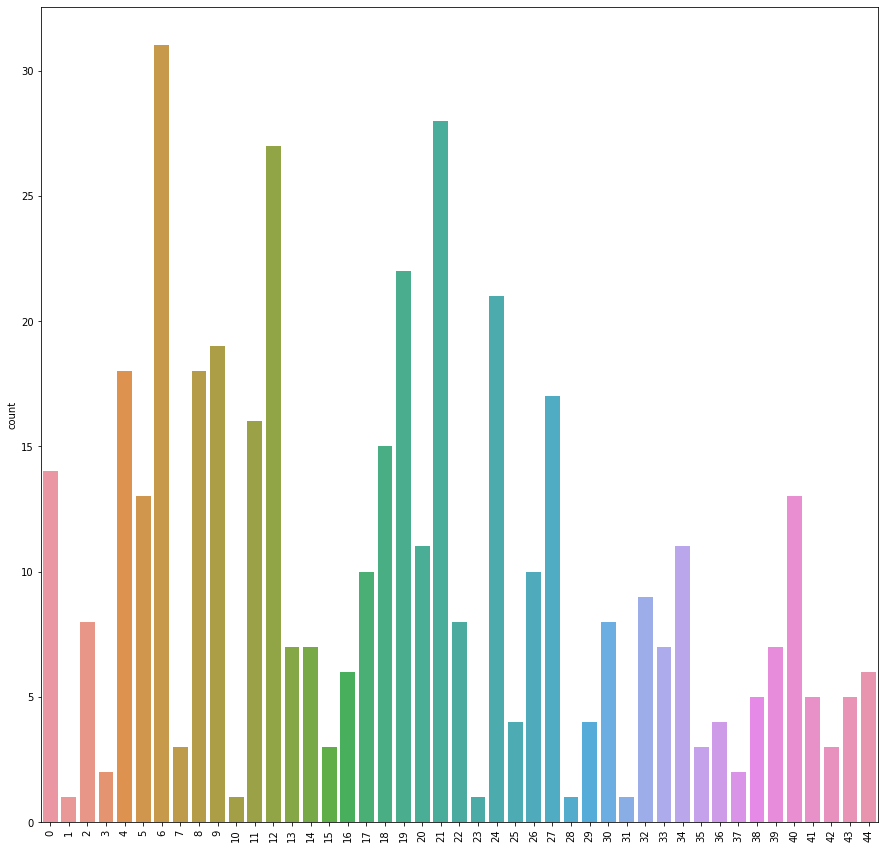

In [ ]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(x=km45.labels_)

In [ ]:
print(pd.DataFrame(list_vect)[km45.labels_==15].word.head(10))
print('--------------------------------')
print(pd.DataFrame(list_vect)[km45.labels_==10].word.head(10))

59     provincial
231    kirchner  
395    liu       
Name: word, dtype: object
--------------------------------
42    o
Name: word, dtype: object


## 6- Analisis clusters, 3 iteraciones

#### iii- Listado de los parámetros usados en la(s) solucion(es) de clustering que se presentan, y lo que se esperaba a priori de cada configuración de parámetros:
- k means con n= 45, 90 y 150 clusters. 

- Listado de parámetros para kmeans. Se dejaron los valores por defecto y solo se modifico el numero n de clusters de 45, 90 y 150. Estos se eligieron así para ver como cambia la distribicion a medida que se duplica la cantidad de clusters.

-DBSCAN parametros: 
eps=2, min_samples=3, se eligieron de esta forma porque al ir variando esta combinacion dio una buena distribucion de clusters con pocos outliers



In [ ]:
km90 =KMeans(n_clusters=90, random_state=0).fit(matrix_num)

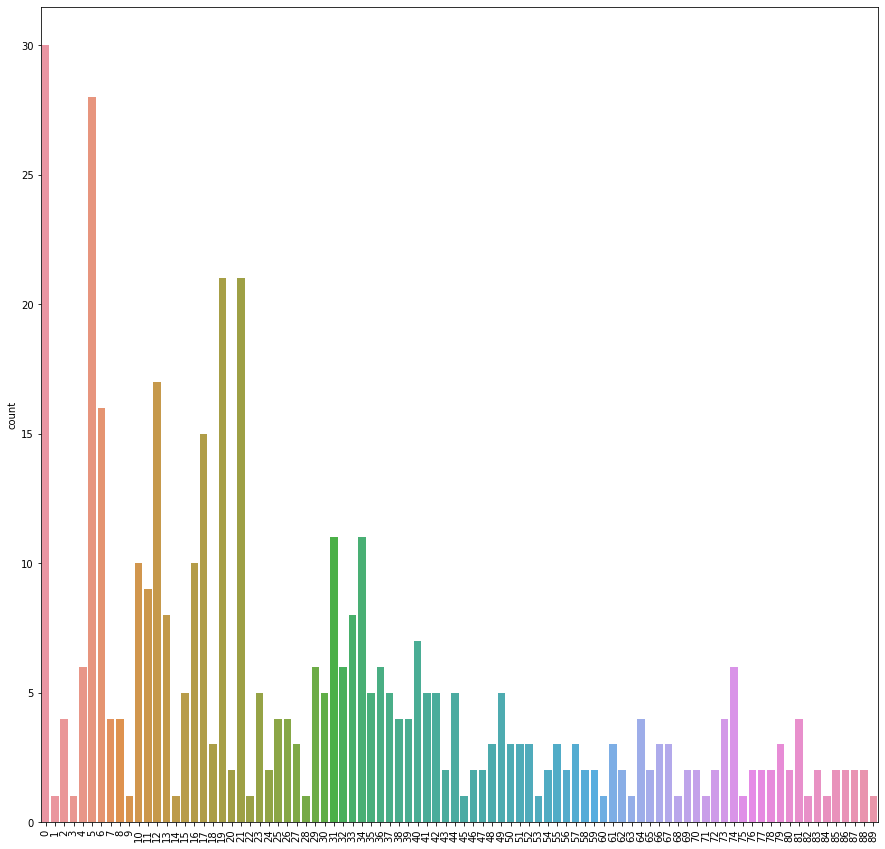

In [ ]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(x=km90.labels_)

In [ ]:
print(pd.DataFrame(list_vect)[km90.labels_==15].word.head(10))
print('--------------------------------')
print(pd.DataFrame(list_vect)[km90.labels_==10].word.head(10))

5      ipem 
291    march
340    ambas
380    jong 
416    pt   
Name: word, dtype: object
--------------------------------
7      belgrano 
118    catalina 
165    francisco
167    cuarto   
309    aires    
330    solá     
338    cta      
358    vigo     
370    mondino  
431    colino   
Name: word, dtype: object


In [ ]:
km150 =KMeans(n_clusters=150, random_state=0).fit(matrix_num)

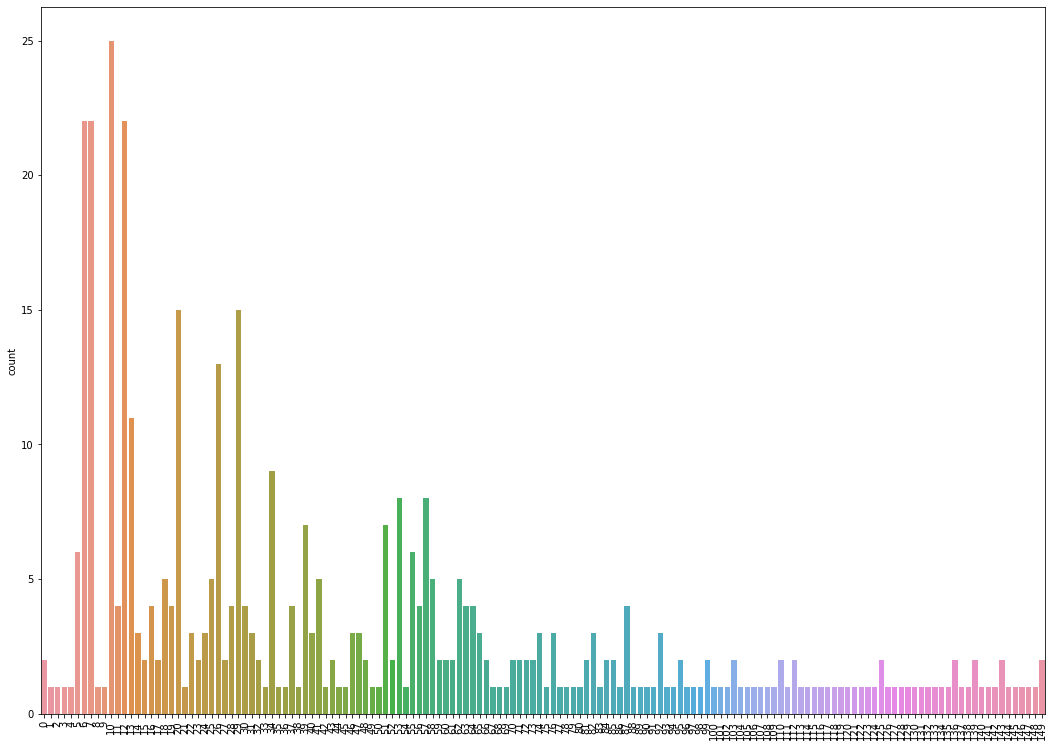

In [ ]:
plt.figure(figsize=(18,13))
plt.xticks(rotation=90)
sns.countplot(x=km150.labels_)

A mayor cantidad de clusters se pueden agrupar menos palabras.

Palabras en el cluster 15 y 10

In [ ]:
print(pd.DataFrame(list_vect)[km150.labels_==15].word.head(10))
print('--------------------------------')
print(pd.DataFrame(list_vect)[km150.labels_==10].word.head(10))

36     mantiene
131    mantener
Name: word, dtype: object
--------------------------------
29     escuelas    
41     movimiento  
74     plantas     
96     humanidad   
114    circuito    
133    tierra      
158    jefes       
160    capacitación
170    habitantes  
175    campos      
Name: word, dtype: object


In [ ]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=2, min_samples=3).fit(matrix_num)
clustering.labels_

array([-1, -1,  0,  1,  2, -1, -1,  3,  4,  5,  6, -1,  7,  5,  2,  5,  8,
       -1,  9, 10,  0, -1,  7, 11, -1, 12, 13, -1,  5, 14, 15, -1, 16, -1,
       -1, 17, 18, -1,  4,  0, -1, 14, -1, 14, 14, -1, 19, 11,  5, -1,  6,
       20, 21, 11, 18, 18, 21, -1,  1, -1, -1, 15, -1, 14, -1,  5, -1, 15,
        0, -1, 22, 23,  5,  9, 14, 12, 23, 22, -1, 24,  0, 20, -1, 19, -1,
       -1, 17, 25, 21, -1, 21, -1,  6, 14, -1,  0, 14, -1,  6, 26,  8, -1,
       -1, -1, 27, 21, -1,  6, -1, -1, -1, -1, 18,  0, 14, 26, 28, -1,  3,
       10, -1, -1, 13, 22, 29, 30, -1, 31, -1,  0, 15, 18, 32, 14,  1, 23,
       -1,  6, -1, 14, -1,  0, -1, 33,  6, 21, 21,  6, 30,  5,  6, -1, -1,
       27,  0, -1, -1, -1, 14,  7, 14, 14, -1, 28, -1,  3, -1,  3,  1, 29,
       14,  7,  5,  6, 26, 14, 14, 21, 32,  1,  5, -1, 18, -1, 14, 24, 22,
       -1,  0,  5, 21,  4, -1,  5, 12, 21,  0, 28, -1, -1, 34,  2, -1,  6,
       24,  6,  0, -1, 20, 21, 14, 23, 14, 14, 21, -1, 15, -1, 32, 15, 22,
       21,  2, 14, 21, -1

In [ ]:
clustering.labels_.max()

38

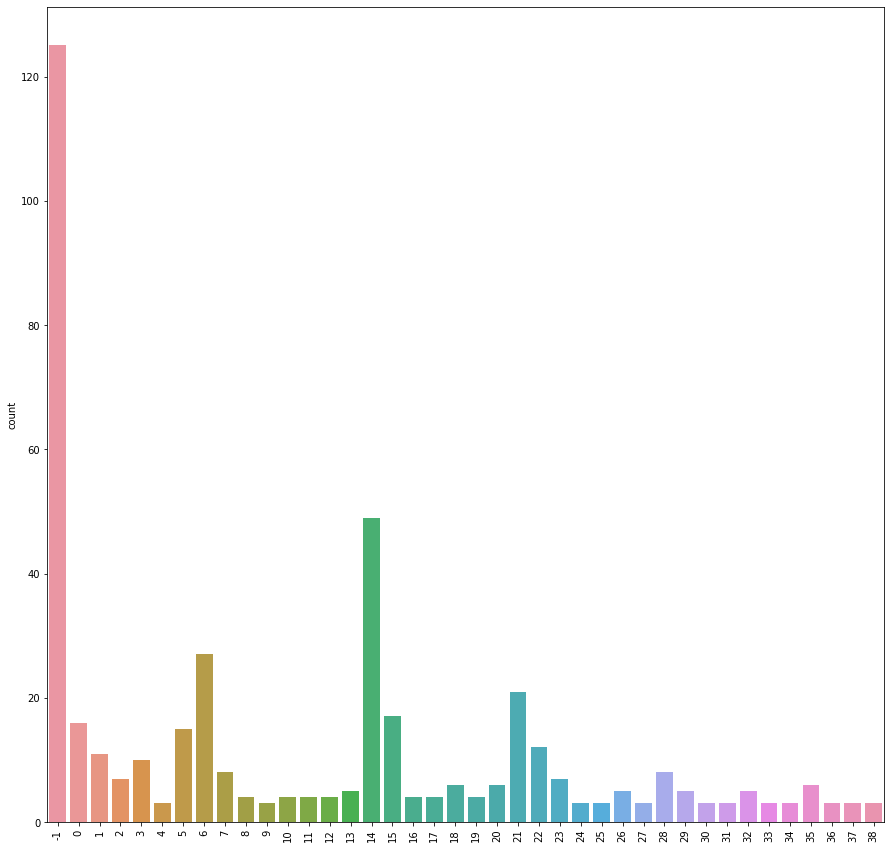

In [ ]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(x=clustering.labels_)

DBSCAN dice que el numero de clusters optimo es 38, pero en este caso el numero de outliers es muy alto.

In [ ]:
print(pd.DataFrame(list_vect)[clustering.labels_==15].word.head(10))
print('--------------------------------')
print(pd.DataFrame(list_vect)[clustering.labels_==10].word.head(10))

30     deán          
61     representantes
67     ciudadanos    
130    estructura    
216    situación     
219    modelo        
242    industria     
243    décadas       
251    ingresos      
271    comerciantes  
Name: word, dtype: object
--------------------------------
19     ministerio
119    jesús     
314    frente    
394    tiananmen 
Name: word, dtype: object


## 4- Aplicar embeddings: LSA o word embeddings neuronales.

Aplico embedings y luego clusters para ver si existe algun tipo de cambio posterior.

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(matrix_num)

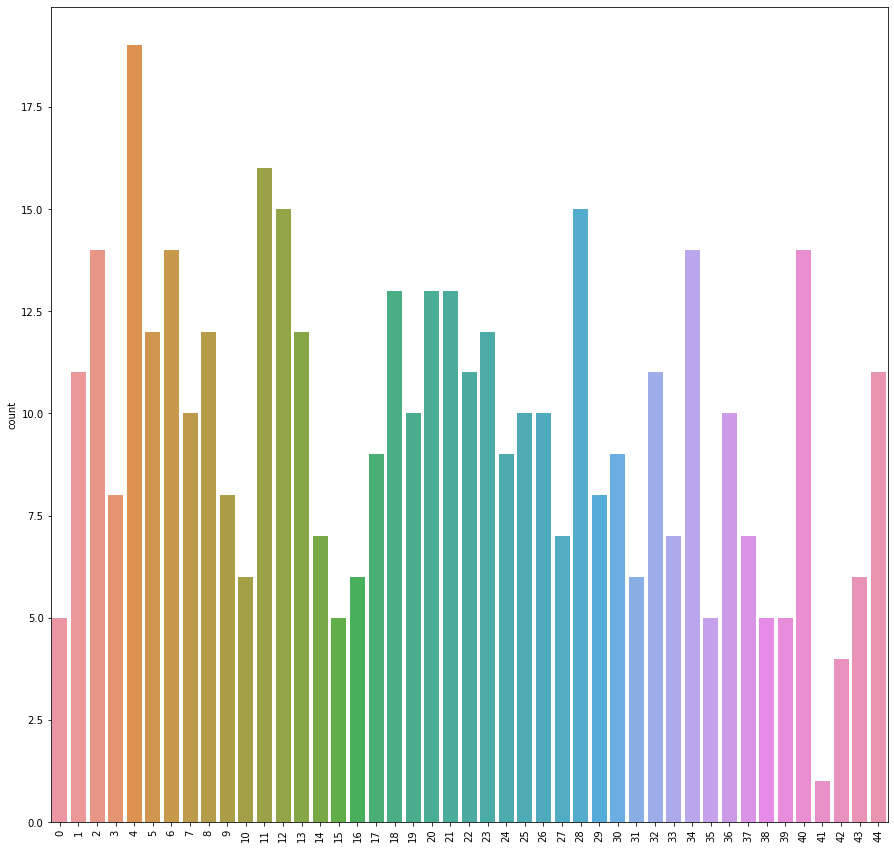

In [ ]:
km90 =KMeans(n_clusters=45, random_state=0).fit(X_embedded)
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(x=km90.labels_)

In [ ]:
print(pd.DataFrame(list_vect)[km90.labels_==15].word.head(10))
print('--------------------------------')
print(pd.DataFrame(list_vect)[km90.labels_==10].word.head(10))

132    kilómetros
178    justicia  
218    espacios  
305    domicilio 
399    prensa    
Name: word, dtype: object
--------------------------------
173    nativos    
181    verde      
203    principales
233    principal  
247    comercial  
269    eventual   
Name: word, dtype: object


Con embeddings la cantidad de palabras por cluster cae en rangos mas acotados.

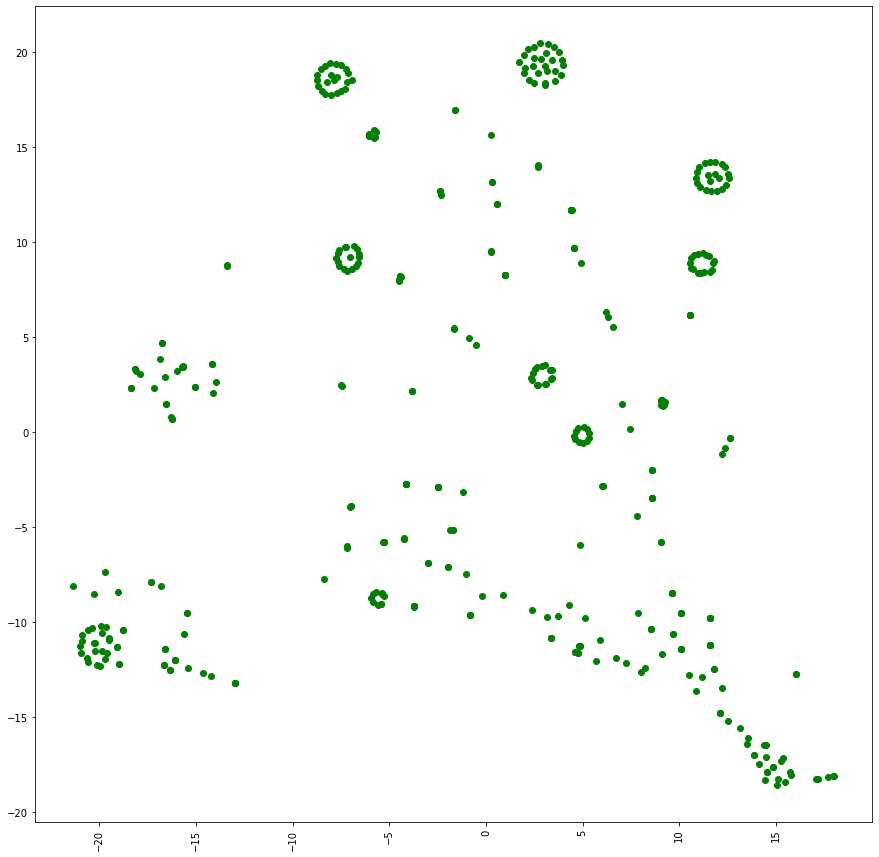

In [ ]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
plt.scatter(X_embedded.transpose()[0], X_embedded.transpose()[1],  c="g")

Gran cantidad de palabras parecen no agruparse en ningun cluster.

In [ ]:
X_embedded = TSNE(n_components=3).fit_transform(matrix_num)

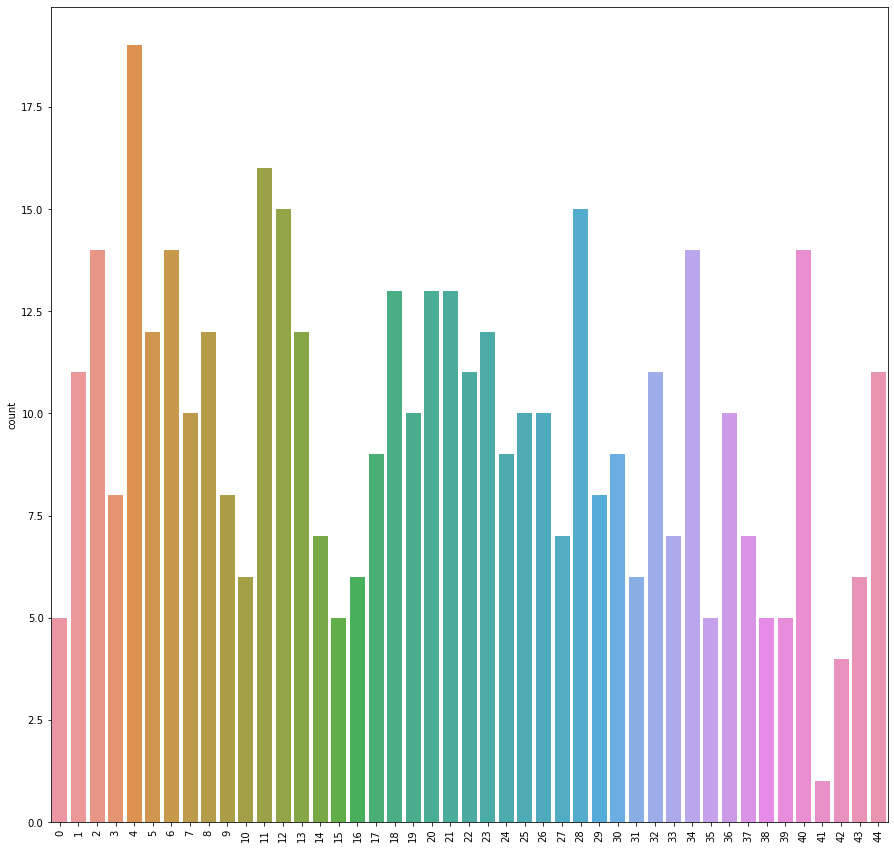

In [ ]:
km90 =KMeans(n_clusters=45, random_state=0).fit(X_embedded)
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(x=km90.labels_)

Probando con la misma cantidad de clusters pero distinta de n_components del embedding no hay cambios notables.

In [ ]:
print(pd.DataFrame(list_vect)[km90.labels_==15].word.head(10))
print('--------------------------------')
print(pd.DataFrame(list_vect)[km90.labels_==10].word.head(10))

6      manuel     
94     unesco     
187    universidad
198    instituto  
230    fernández  
315    luis       
357    alejandra  
Name: word, dtype: object
--------------------------------
8      toma       
38     posibilidad
97     estancias  
125    presidente 
148    viernes    
299    política   
426    policía    
Name: word, dtype: object


#### iv- Discusión de la(s) solucion(es) de clustering elegidas: descripción global de la solución (número de clusters, cantidad de elementos por cluster, distribución de características, algunas métricas) y descripción cualitativa de algunos clusters:

- Debido a la falta de recursos (RAM) se limito el numero de palabras lo que provoco que no se pudieran armar muchos clusters ya que esto significaria una palabra por cluster. Teniendo esto en cuenta se determino que 45 clusters resultaron los mas optimos con una buena distribucion de clusters. Al usar embeddings se mejoro esa distribucion para n= 2, aunque no se observaron cambios para n= 3.

Ademas con un scatter- plot que se les hizo a los datos embebidos se obtuvieron al menos 13 posibles grupos.


